In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [4]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [8]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [9]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(10, 10) (1, 10)
(10, 10) (1, 10)
Alphas for hard margins:  [[1.56617810e-10]
 [4.94957650e-11]
 [4.28625946e-11]
 [4.22695866e-10]
 [1.13727208e-10]
 [5.26949086e-11]
 [5.47778322e-11]
 [4.66228462e-11]
 [2.31014659e+00]
 [8.70556589e-11]
 [2.21444350e-10]
 [1.60119236e-10]
 [9.87498333e-11]
 [5.00417858e-10]
 [5.46120825e-11]
 [4.78956057e-11]
 [4.53154782e-11]
 [7.21479057e-11]
 [9.11001562e-11]
 [4.67440389e-11]
 [2.54393179e-10]
 [4.13155564e-10]
 [5.41516772e-11]
 [4.35026039e-10]
 [5.86230707e-11]
 [3.38203231e-11]
 [3.69409221e-10]
 [4.60323368e-11]
 [4.25448627e-10]
 [9.65835129e-11]
 [1.49641455e-10]
 [7.14957073e-11]
 [4.57441662e-11]
 [1.16449692e-10]
 [5.50853988e-11]
 [8.51880795e+01]
 [7.19360877e-11]
 [2.32501311e+01]
 [6.23613498e-11]
 [1.15703205e-10]
 [4.53191401e-10]
 [5.06605043e-11]
 [1.17085444e-10]
 [1.28414834e-10]
 [6.48441974e-11]
 [9.00906741e-11]
 [2.03388910e-10]
 [2.50048566e-10]
 [8.94280424e-11]
 [5.05425660e-10]
 [7.63878730e-11]
 [2.31001962e+01]
 [4.

In [10]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[3.70868777e-12]
 [1.16112130e-12]
 [9.88948603e-13]
 [1.11051412e-11]
 [2.67621763e-12]
 [1.19078493e-12]
 [1.27200104e-12]
 [1.07742199e-12]
 [2.31014660e+00]
 [2.02614284e-12]
 [5.92026633e-12]
 [3.58870719e-12]
 [2.35940090e-12]
 [1.20284530e-11]
 [1.32127440e-12]
 [1.08730944e-12]
 [1.02996517e-12]
 [1.68039741e-12]
 [2.19564447e-12]
 [1.09638617e-12]
 [6.52189626e-12]
 [9.50490611e-12]
 [1.26594546e-12]
 [1.33859137e-11]
 [1.40116874e-12]
 [7.97108173e-13]
 [8.67159996e-12]
 [1.04132041e-12]
 [9.47445148e-12]
 [2.26734198e-12]
 [3.68287086e-12]
 [1.62714394e-12]
 [1.05989629e-12]
 [2.89826358e-12]
 [1.27343044e-12]
 [8.51880795e+01]
 [1.70052390e-12]
 [2.32501311e+01]
 [1.44189539e-12]
 [2.68995883e-12]
 [1.21691064e-11]
 [1.17570712e-12]
 [2.94929673e-12]
 [3.03284154e-12]
 [1.47934417e-12]
 [2.14053687e-12]
 [4.87645655e-12]
 [6.20578184e-12]
 [2.08840620e-12]
 [1.27314186e-11]
 [1.77126541e-12]
 [2.31001962e+01]
 [1.07675612e-12]
 [2.83160121e-12]
 [

<a list of 3 text.Text objects>

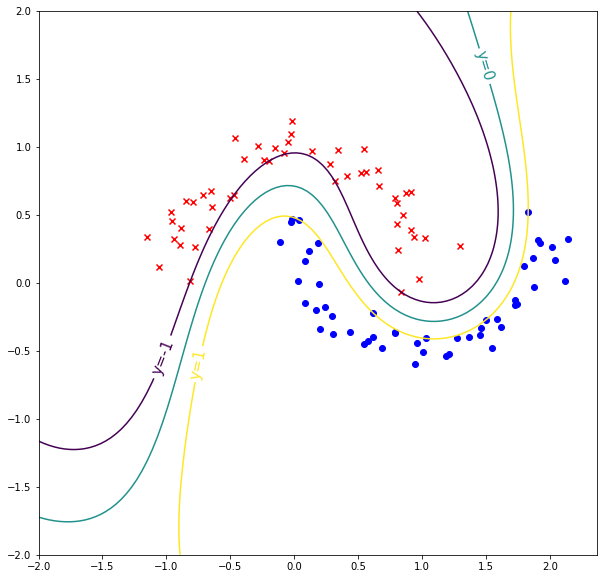

In [11]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)

<a list of 3 text.Text objects>

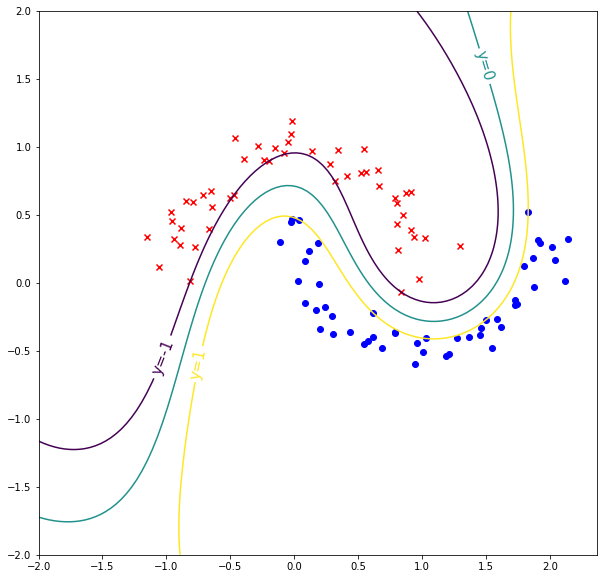

In [12]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)
